# Collaboration and Competition: Project #3 Tennis


##  Udacity - Reinforcement Learning Nanodegree
### Student: Geoffey Shmigelsky
---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

The purpose of the project is to train a Deep Learning on a Unity built Tennis environment. The idea is to have two agents play a game of tennis.

There are 24 dimenions of input and 2 continuous actions per agent. The agent is tasked with acheiving a maxed score of +0.5 averaged over 100 episodes.


### Sample output from a Trained Agent

![Sample Agent](tennis_image.png)

### Acknowledgements

As per the instructions for the project, much of the code is copied from the Pendulum DDPG project in the Deep Reinforcement Learning class folder, originally used in Project #2:

https://github.com/udacity/deep-reinforcement-learning

## Required

This project requires:

1. Numpy
2. Torch 
3. MatplotLib
4. Python Kernal and UnityEnvironment provided by Udacity


## Resources
Continuous control deep reinforcement learning: 
https://arxiv.org/abs/1509.02971

Benchmarking Deep Reinforcement Learning Continuous Control: 
https://arxiv.org/abs/1604.06778
        


### 1. Start the Environment

We begin by importing  necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import gym
import random
import torch

import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent


### 2. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Tennis Challenge

The Tennis.app is a Unity based game simulation. 

The purpose of the game is to move two tennis players so they can lob a ball back and force over a net.

It is a complex challenge where tennis rackets must coordinate their efforts.

The goal of the game is get to score of 0.50. If the agents can acheive an average score of 0.50 over 100 episodes, that is considered success.



In [2]:
# Mac
# file_name='Envs/Apple.app'

# Windows
# file_name = 'Envs/Linux/Tennis.x86_64'

# Linux with Visualization
# file_name = 'Envs/Windows/Tennis.x86_64'

# Linux No Visualization
file_name = 'Envs/Linux_NoVis/Tennis.x86_64'

# setup the environment - 
env = UnityEnvironment(file_name=file_name) 

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the game state
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Game Mechanics

The Tennis challenge is non-trival environment. 

The action space consists of two (2) continuous actions to control movement of two (2) tennis rackets.

The state space considers of 24 continous or discrete dimensions. What each of the dimensions mean is unknown. 

For the purpose of the learner (agent), not knowing what the state dimenensions or the actions mean is the whole point. The agent's task is to learn what action to take when, by experiencing trial and error. 

In [3]:
def explain(name, data, detail=True):
    print('-' * 10, name, '-' * 10)
    if isinstance(data, np.ndarray):
        print("Shape of numpy array:", data.shape)
    elif isinstance(data, list):
        print("Type: {}, Length: {}".format(type(data), len(data)))
    else:
        print("Type: {}, {}", format(type(data), data))
        
    if detail: 
        print(data)
    print()
    

In [4]:
# environment parameters
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size 
state_size = env_info.vector_observations.shape[1]

print("Environment      : ", file_name)
print("Number of agents : ", num_agents)
print("Number of actions: ", action_size)
print("Number of states : ", state_size)
print()

# Agents space
explain("Env Agents", env_info.agents, detail=True)

# Actions vector space
explain("Env Actions Vector", env_info.previous_vector_actions, detail=False)

# Single Action
explain("Env Single Agent's Actions 0", env_info.previous_vector_actions[0])
explain("Env Single Agent's Actions 1", env_info.previous_vector_actions[1])

# States space
explain("Env States", env_info.vector_observations, detail=False) 

# Single Statenum_agents
explain("Env Single Agent State 0", env_info.vector_observations[0])
explain("Env Single Agent State :", env_info.vector_observations[1])

# Reward space
explain("Env Rewards", env_info.rewards)      

# Done space
explain("Env Dones", env_info.local_done)



Environment      :  Envs/Linux_NoVis/Tennis.x86_64
Number of agents :  2
Number of actions:  2
Number of states :  24

---------- Env Agents ----------
Type: <class 'list'>, Length: 2
[942, 952]

---------- Env Actions Vector ----------
Shape of numpy array: (2, 2)

---------- Env Single Agent's Actions 0 ----------
Shape of numpy array: (2,)
[0. 0.]

---------- Env Single Agent's Actions 1 ----------
Shape of numpy array: (2,)
[0. 0.]

---------- Env States ----------
Shape of numpy array: (2, 24)

---------- Env Single Agent State 0 ----------
Shape of numpy array: (24,)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]

---------- Env Single Agent State : ----------
Shape of numpy array: (24,)
[ 0.          0.          0.          0.          0.          0.
  0.     

## DDPG Agent

The DDPG Agent will iterate over episodes until the goal is reached. The goal is an average score greater or equal to 0.5 averaged ver 100 episodes; averaged over all robotic arms.

The DDPG function differs from most reinforcement learning OpenAI loops in the the (state, reward, next state, done) has to be manually extracted from the environment.

Training is done through a batch process, every 20 iterations 10 training sessions are invoked.

In [5]:
def maddpg(env, agent, num_agents, state_size, action_size, target_score, num_episodes=2500, num_tries=1000, print_every=50):
    scores_deque = deque(maxlen=100) 
    scores_history = []
    scores_both = []
    time_history = []
    solved_count = 0
    solved_flag = False
    
    # itterate over number of episodes
    for e in range(num_episodes):
        # reset environment and agent
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        actions = np.zeros((num_agents, action_size))          # initialize the action space (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()

        start_time = time.time()
        
        # itterate over the number of tries
        for t in range(num_tries):
            # choose an action
            actions = agent.act(states)
            
            # take an action
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            
            # S,A,R,S result
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if an episode finished

            # update the agent's history
            for s,a,r,ns,d in zip(states, actions, rewards, next_states, dones):
                agent.step(s,a,r,ns,d)

            # train the agent in batches, 10 times after 20 timesteps - Attempt #4 class notes
            if t % 20 == 0:
                for _ in range(10):
                    agent.learn_batch()
               
            # track scores, itterate to next step
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to the next step
            
            if np.any(dones):
                break
        
        # track how long each episode takes
        end_time = time.time()
        duration = end_time - start_time
        time_history.append(duration)
        
        # compute max score for all agents and deque
        max_score = np.max(scores) # this is the only change from Project 2 to Project 3
        scores_history.append(max_score)

        scores_both.append(scores)
        
        scores_deque.append(max_score)
        mean_deque =  np.mean(scores_deque)
        
        # save for plotting
        np.savetxt('scores_max.txt', scores_history, fmt='%f')
        np.savetxt('scores_both.txt', scores_both, fmt='%f')        
        np.savetxt('time.txt', time_history, fmt='%f')
        
        # report
        end = "\n" if e % print_every == 0 else ""
        print('\rEpisode: {:3d}\tMax Agents Score: {:2.2f}\t Deque Score: {:2.2f}\t Time: {:2.1f} seconds'.format(e, max_score, mean_deque, duration), end=end)
        
        # announce game solved and continue for more steps for graphing 
        if mean_deque >= target_score and solved_flag == False and e >= 100:
            print("\n\n=== SOLVED === at episode {:3d} with score {:.2f}\n".format(e, mean_deque))
            
            # save agent for demonstrationformat(e, mean_score, mean_deque, duration
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')               
            
            solved_flag = True
          
        if solved_flag: 
            solved_count += 1
            
        # continue past winning to see if it is still stable            
        if solved_flag and solved_count > 500:
            break         
        
    print()
        
    return scores_history, time_history            



## Run the Training Process

First create an agent with meta parameters as need.

Second, run the training maddpg function. It will train until the target_score is reached. 

Finally, the scores are save to disk.

The trained model is also saved as checkpoint.pth for both the actor and critic.

In [6]:
print("CUDA Torch       : ", torch.cuda.is_available())
print("Environment      : ", file_name)
print("Number of agents : ", num_agents)
print("Number of actions: ", action_size)
print("Number of states : ", state_size)
print()

episodes = 2500
tries = 1000
target = 0.5
seed = 42

agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

%time _, _ = maddpg(env=env, agent=agent, num_agents=num_agents, \
                      target_score=target, \
                      state_size=state_size, action_size=action_size, \
                      num_episodes=episodes, num_tries=tries)


CUDA Torch       :  True
Environment      :  Envs/Linux_NoVis/Tennis.x86_64
Number of agents :  2
Number of actions:  2
Number of states :  24

Episode:   0	Max Agents Score: 0.00	 Deque Score: 0.00	 Time: 0.1 seconds
Episode:  13	Max Agents Score: 0.10	 Deque Score: 0.01	 Time: 0.0 seconds

/home/geoffrey/Dropbox/RLND/Project3/ddpg_agent.py:106: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode:  50	Max Agents Score: 0.00	 Deque Score: 0.01	 Time: 0.1 seconds
Episode: 100	Max Agents Score: 0.00	 Deque Score: 0.00	 Time: 0.1 seconds
Episode: 150	Max Agents Score: 0.00	 Deque Score: 0.00	 Time: 0.1 seconds
Episode: 200	Max Agents Score: 0.10	 Deque Score: 0.02	 Time: 0.2 seconds
Episode: 250	Max Agents Score: 0.00	 Deque Score: 0.02	 Time: 0.1 seconds
Episode: 300	Max Agents Score: 0.00	 Deque Score: 0.01	 Time: 0.1 seconds
Episode: 350	Max Agents Score: 0.00	 Deque Score: 0.01	 Time: 0.1 seconds
Episode: 400	Max Agents Score: 0.10	 Deque Score: 0.03	 Time: 0.2 seconds
Episode: 450	Max Agents Score: 0.00	 Deque Score: 0.05	 Time: 0.1 seconds
Episode: 500	Max Agents Score: 0.10	 Deque Score: 0.05	 Time: 0.2 seconds
Episode: 550	Max Agents Score: 0.00	 Deque Score: 0.03	 Time: 0.1 seconds
Episode: 600	Max Agents Score: 0.00	 Deque Score: 0.00	 Time: 0.1 seconds
Episode: 650	Max Agents Score: 0.10	 Deque Score: 0.03	 Time: 0.2 seconds
Episode: 700	Max Agents Score: 0.10	 D

In [7]:
env.close()

## Plotting

The plot will show key aspects of the learning process:

Blue - Current episode score

Orange - Target of 0.5

Purple - Running average over all episodes

Red - The key metric, the average score over 100 episodes

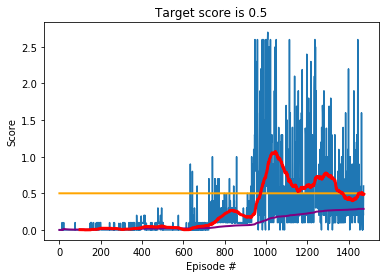

In [10]:
# Plot Scores and Deque history

scores = np.loadtxt('scores_max.txt', dtype=float)

# computed 100 rolling average
weights = np.ones(100) / 100      
mean_100 = np.zeros(100)
running_ave = np.zeros(len(scores))

for i in range(1,100):
    mean_100[i] = np.mean(scores[0:i])

for i in range(1,len(scores)):
    running_ave[i] = np.mean(scores[0:i])
    
mean_100[:] = np.NAN   
mean_100 = np.append(mean_100, np.convolve(scores, weights, mode='valid'))

# create a line showing target
target_line = np.zeros(len(scores))
target_line[:] = 0.5
1
# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(target_line)), target_line, color='orange', linewidth=2)
plt.plot(np.arange(len(target_line)), running_ave, color='purple', linewidth=2)
plt.plot(np.arange(len(mean_100)), mean_100, color='red', linewidth=3)

plt.title("Target score is {}".format(target))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


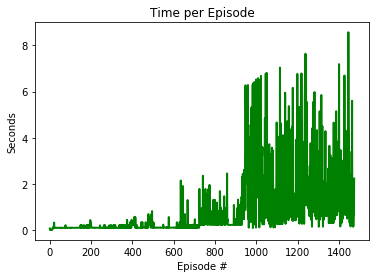

In [12]:
# Plot time history

times = np.loadtxt('time.txt', dtype=float)
  
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(times)), times, color='green', linewidth=2)

plt.title("Time per Episode")
plt.ylabel('Seconds')
plt.xlabel('Episode #')
plt.show()
